In [31]:
pip install torch torchvision matplotlib

#1. Xây dựng mô hình AlexNet
AlexNet bao gồm một số lớp Convolutional (Conv) để trích xuất đặc trưng, một số lớp Fully Connected (FC) để phân loại, và một số lớp dropout để tránh overfitting.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

class ModifiedAlexNet(nn.Module):
    # def __init__(self, num_classes=10):
    #     super(AlexNet, self).__init__()

    #     # Lớp convolutional đầu tiên
    #     self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
    #     self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
    #     self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
    #     self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
    #     self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)

    #     # Các lớp pooling
    #     self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

    #     # Các lớp Fully Connected (FC)
    #     self.fc1 = nn.Linear(256 * 6 * 6, 4096)
    #     self.fc2 = nn.Linear(4096, 4096)
    #     self.fc3 = nn.Linear(4096, num_classes)

    #     # Lớp dropout để tránh overfitting
    #     self.dropout = nn.Dropout(p=0.5)

    # def forward(self, x):
    #     # Forward pass qua các lớp convolutional và pooling
    #     x = self.pool(torch.relu(self.conv1(x)))
    #     x = self.pool(torch.relu(self.conv2(x)))
    #     x = torch.relu(self.conv3(x))
    #     x = self.pool(torch.relu(self.conv4(x)))
    #     x = self.pool(torch.relu(self.conv5(x)))

    #     # Chuyển đổi hình ảnh 2D thành vector 1D trước khi đưa vào các lớp FC
    #     x = x.view(x.size(0), -1)

    #     # Forward pass qua các lớp Fully Connected và dropout
    #     x = torch.relu(self.fc1(x))
    #     x = self.dropout(x)
    #     x = torch.relu(self.fc2(x))
    #     x = self.dropout(x)
    #     x = self.fc3(x)

    #     return x
    def __init__(self, num_classes=10):
        super(ModifiedAlexNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 4096)  # Update this line
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))  # Additional pooling layer
        x = torch.relu(self.conv5(x))

        # Flattening the tensor before passing to fully connected layers
        x = x.view(-1, 512 * 2 * 2)  # Use the updated size
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

#2. Cài đặt và chuẩn bị dữ liệu
Dữ liệu CIFAR-10 là một tập dữ liệu phổ biến với 60,000 ảnh chia thành 10 lớp khác nhau. Để sử dụng, chúng ta cần chuẩn bị dữ liệu và thực hiện các phép biến đổi như chuẩn hóa ảnh.

In [33]:
# Cấu hình các phép biến đổi ảnh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải dữ liệu CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Tạo DataLoader cho train và test
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


#3. Huấn luyện mô hình
Sau khi đã xây dựng mô hình và chuẩn bị dữ liệu, chúng ta sẽ huấn luyện mô hình với một hàm mất mát như CrossEntropyLoss và tối ưu hóa bằng thuật toán Adam.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

# Kiểm tra xem có GPU hay không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo mô hình, hàm mất mát và optimizer
model = ModifiedAlexNet(num_classes=10).to(device)  # Chuyển mô hình vào GPU (nếu có)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        # Đưa dữ liệu vào GPU (nếu có)
        inputs, labels = inputs.to(device), labels.to(device)

        # Đặt gradient về 0, thực hiện phép truyền ngược và cập nhật trọng số
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tính toán loss và độ chính xác
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct/total:.2f}%')


Epoch [1/60], Loss: 1.5252, Accuracy: 41.74%
Epoch [2/60], Loss: 1.0432, Accuracy: 63.05%
Epoch [3/60], Loss: 0.8391, Accuracy: 70.72%
Epoch [4/60], Loss: 0.6910, Accuracy: 75.63%
Epoch [5/60], Loss: 0.5758, Accuracy: 80.02%
Epoch [6/60], Loss: 0.4734, Accuracy: 83.41%
Epoch [7/60], Loss: 0.3925, Accuracy: 86.30%
Epoch [8/60], Loss: 0.3186, Accuracy: 88.85%
Epoch [9/60], Loss: 0.2649, Accuracy: 90.85%
Epoch [10/60], Loss: 0.2164, Accuracy: 92.62%
Epoch [11/60], Loss: 0.2002, Accuracy: 93.33%
Epoch [12/60], Loss: 0.1586, Accuracy: 94.72%
Epoch [13/60], Loss: 0.1634, Accuracy: 94.62%
Epoch [14/60], Loss: 0.1308, Accuracy: 95.61%
Epoch [15/60], Loss: 0.1402, Accuracy: 95.41%
Epoch [16/60], Loss: 0.1115, Accuracy: 96.45%
Epoch [17/60], Loss: 0.1096, Accuracy: 96.45%
Epoch [18/60], Loss: 0.1059, Accuracy: 96.65%
Epoch [19/60], Loss: 0.0984, Accuracy: 96.74%
Epoch [20/60], Loss: 0.0995, Accuracy: 96.82%
Epoch [21/60], Loss: 0.0933, Accuracy: 97.09%
Epoch [22/60], Loss: 0.0916, Accuracy: 97.0

#4. Đánh giá mô hình trên tập kiểm tra
Sau khi huấn luyện, chúng ta sẽ cần đánh giá mô hình trên tập kiểm tra để kiểm tra hiệu quả của nó.

In [35]:
# Đánh giá mô hình
model.eval()  # Chuyển mô hình sang chế độ evaluation
correct = 0
total = 0

with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm bộ nhớ
    for inputs, labels in testloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 74.73%


In [36]:
# Lưu mô hình đã huấn luyện
torch.save(model.state_dict(), "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Alexnet.pth")

<ipython-input-39-e38bb9facb65>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Ve

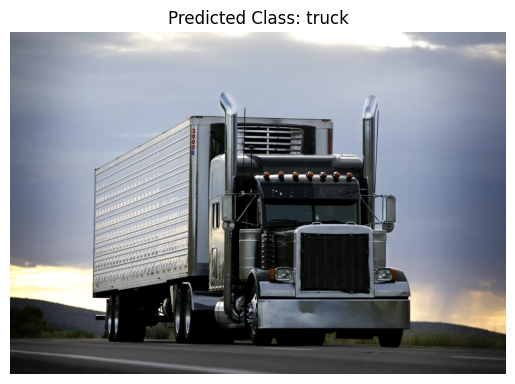

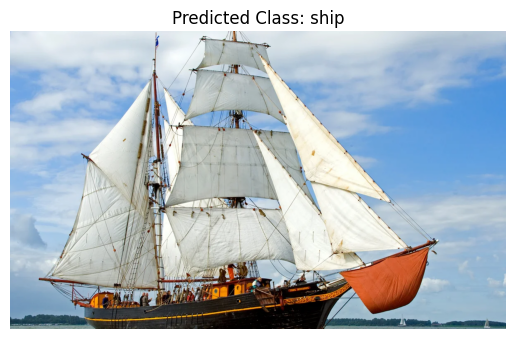

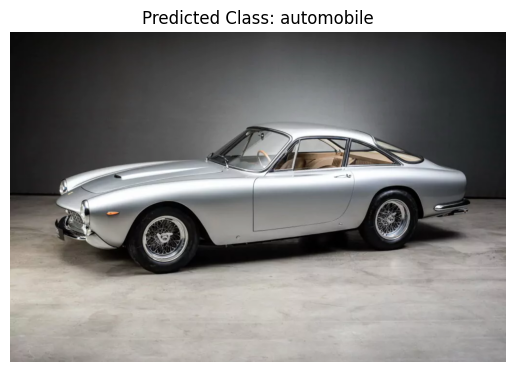

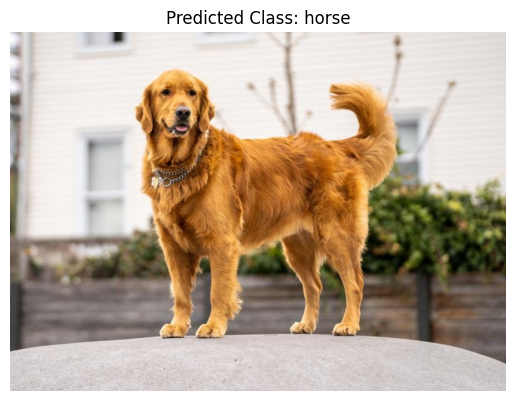

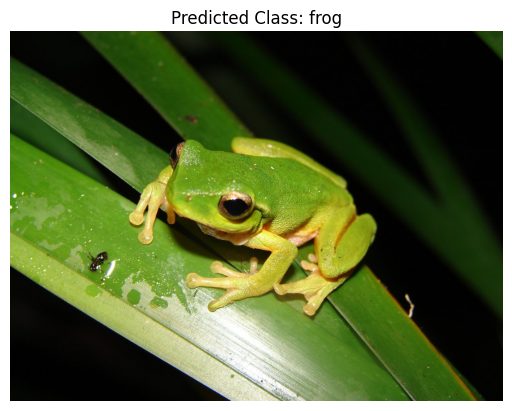

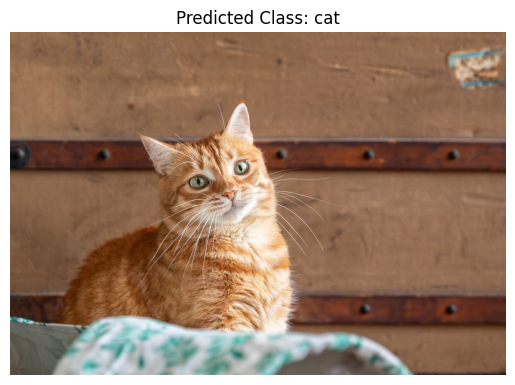

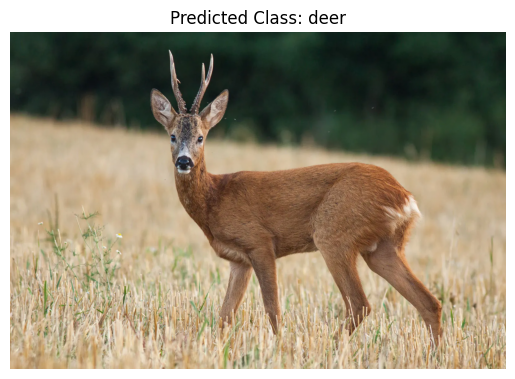

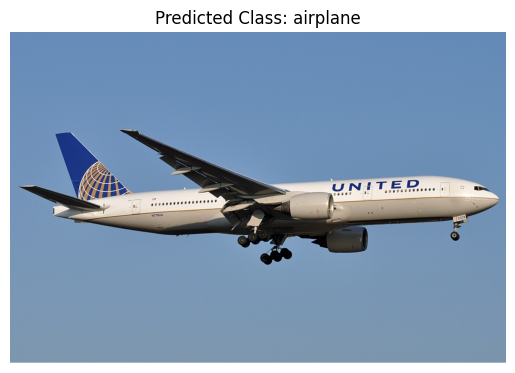

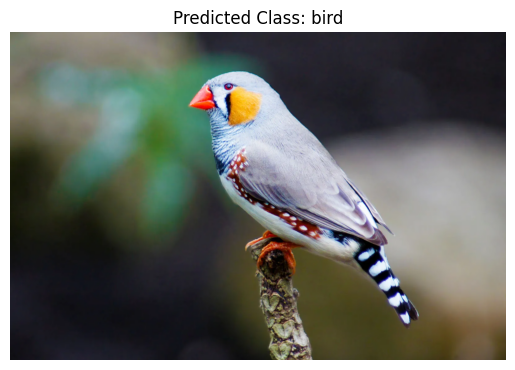

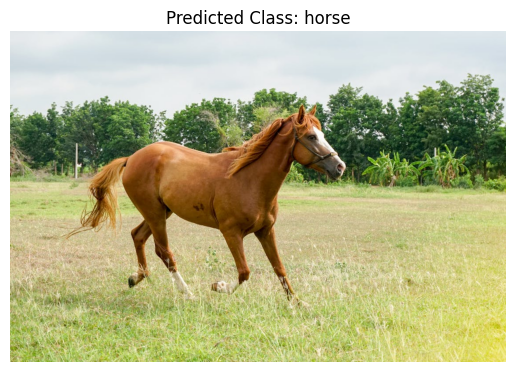

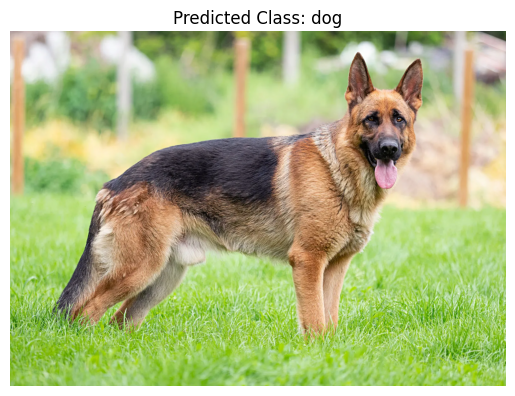

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# # Định nghĩa mô hình (ModifiedAlexNet)
# class ModifiedAlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ModifiedAlexNet, self).__init__()

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
#         self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

#         # Pooling
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

#         # Fully connected layers
#         self.fc1 = nn.Linear(512 * 2 * 2, 4096)  # Update this line
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, num_classes)

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = self.pool(torch.relu(self.conv3(x)))
#         x = self.pool(torch.relu(self.conv4(x)))  # Additional pooling layer
#         x = torch.relu(self.conv5(x))

#         # Flattening the tensor before passing to fully connected layers
#         x = x.view(-1, 512 * 2 * 2)  # Use the updated size
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

# # Cấu hình các phép biến đổi ảnh
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Tải mô hình đã huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedAlexNet(num_classes=10).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Alexnet.pth", map_location=device))  # Chọn đúng đường dẫn đến mô hình đã lưu
model.eval()

# Hàm nhận diện đối tượng trong hình ảnh
def predict_image(image_path):
    # Đọc và tiền xử lý hình ảnh
    image = Image.open(image_path)
    image = image.resize((32, 32))  # Resize về kích thước 32x32 để phù hợp với mô hình
    image_tensor = transform(image).unsqueeze(0).to(device)  # Chuyển đổi sang tensor và thêm batch dimension

    # Tiến hành dự đoán
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Dự đoán lớp có xác suất cao nhất

    # Lấy tên lớp từ chỉ số dự đoán
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    predicted_class = classes[predicted.item()]
    return predicted_class

# Hình ảnh đầu vào cần nhận diện
image_path01 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Semi-Truck-Fact-scaled.webp"  # Đảm bảo hình ảnh có thể được tải lên
image_path02 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/2740.webp"
image_path03 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Ferrari-250-GT-001-1024x682.jpg.pagespeed.ce.S3zFC4eb83.webp"
image_path04 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Golden+Retrievers+dans+pet+care.jpeg"
image_path05 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Green_Leaf_Tree_Frog.width-1200.febd90e.jpg"
image_path06 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Molly_006-2829x1886-2726x1886.jpg"
image_path07 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Roe-deer-antlers-buck-slovakia.webp"
image_path08 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/United_Airlines_Boeing_777-200_Meulemans.jpg"
image_path09 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/Zebra-finch-Taeniopygia-guttata-bird.webp"
image_path10 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/pexels-photo-6696645.jpeg"
image_path11 = "/content/drive/MyDrive/10%_Of_Progress2_ComputerVision/Version3/German-Shepherd-dog-Alsatian.webp"

# Dự đoán
predicted_class01 = predict_image(image_path01)
predicted_class02 = predict_image(image_path02)
predicted_class03 = predict_image(image_path03)
predicted_class04 = predict_image(image_path04)
predicted_class05 = predict_image(image_path05)
predicted_class06 = predict_image(image_path06)
predicted_class07 = predict_image(image_path07)
predicted_class08 = predict_image(image_path08)
predicted_class09 = predict_image(image_path09)
predicted_class10 = predict_image(image_path10)
predicted_class11 = predict_image(image_path11)

# Hiển thị kết quả
image01 = Image.open(image_path01)
plt.imshow(image01)
plt.title(f"Predicted Class: {predicted_class01}")
plt.axis('off')
plt.show()

image02 = Image.open(image_path02)
plt.imshow(image02)
plt.title(f"Predicted Class: {predicted_class02}")
plt.axis('off')
plt.show()

image03 = Image.open(image_path03)
plt.imshow(image03)
plt.title(f"Predicted Class: {predicted_class03}")
plt.axis('off')
plt.show()

image04 = Image.open(image_path04)
plt.imshow(image04)
plt.title(f"Predicted Class: {predicted_class04}")
plt.axis('off')
plt.show()

image05 = Image.open(image_path05)
plt.imshow(image05)
plt.title(f"Predicted Class: {predicted_class05}")
plt.axis('off')
plt.show()

image06 = Image.open(image_path06)
plt.imshow(image06)
plt.title(f"Predicted Class: {predicted_class06}")
plt.axis('off')
plt.show()

image07 = Image.open(image_path07)
plt.imshow(image07)
plt.title(f"Predicted Class: {predicted_class07}")
plt.axis('off')
plt.show()

image08 = Image.open(image_path08)
plt.imshow(image08)
plt.title(f"Predicted Class: {predicted_class08}")
plt.axis('off')
plt.show()

image09 = Image.open(image_path09)
plt.imshow(image09)
plt.title(f"Predicted Class: {predicted_class09}")
plt.axis('off')
plt.show()

image10 = Image.open(image_path10)
plt.imshow(image10)
plt.title(f"Predicted Class: {predicted_class10}")
plt.axis('off')
plt.show()

image11 = Image.open(image_path11)
plt.imshow(image11)
plt.title(f"Predicted Class: {predicted_class11}")
plt.axis('off')
plt.show()